# HW3 Kalman Filters for GPS IMU fusion

I used a ROS1 docker image to convert rosbags into 2 separate csv files for imu and gps data

I mounted the data directory to the docker container to share files.

$ docker run -it --mount type=bind,src=/home/anatharv1/EECE7150/HW3/data,dst=/rosbags/data osrf/ros:noetic-desktop-full bash

Running rostopic commands to get the csv files

$ rostopic echo -b gps_imu_nuance.bag -p /gps/fix>gps_rosbag.csv

$ rostopic echo -b gps_imu_nuance.bag -p /imu/imu_uncompensated>imu_rosbag.csv

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import plotly.express as px
from matplotlib.lines import Line2D   
import numpy as np

In [2]:
df_gps = pd.read_csv("data/gps_rosbag.csv", delimiter=',', skiprows=0, low_memory=False)
print(df_gps.columns)
print("Number of rows:", df_gps.shape[0])
print(df_gps.head())

Index(['%time', 'field.header.seq', 'field.header.stamp',
       'field.header.frame_id', 'field.status.status', 'field.status.service',
       'field.latitude', 'field.longitude', 'field.altitude',
       'field.position_covariance0', 'field.position_covariance1',
       'field.position_covariance2', 'field.position_covariance3',
       'field.position_covariance4', 'field.position_covariance5',
       'field.position_covariance6', 'field.position_covariance7',
       'field.position_covariance8', 'field.position_covariance_type'],
      dtype='object')
Number of rows: 30758
                 %time  field.header.seq   field.header.stamp  \
0  1697739278762009759               322  1697739278761564970   
1  1697739278861499253               323  1697739278861115217   
2  1697739278961962927               324  1697739278961461782   
3  1697739279061906874               325  1697739279061564683   
4  1697739279163294838               326  1697739279162702798   

  field.header.frame_id  f

In [3]:
# drop rows without coordinates
df_valid_gps = df_gps.dropna(subset=['field.latitude', 'field.longitude']).copy()
print("Valid rows: ", df_valid_gps.shape[0])


center = {'lat': df_valid_gps['field.latitude'].mean(), 'lon': df_valid_gps['field.longitude'].mean()}
fig = px.scatter_map(df_valid_gps,
                        lat="field.latitude",
                        lon="field.longitude",
                        hover_name="field.header.stamp",
                        zoom=13,
                        height=1200,
                        width=1200)
fig.update_layout(mapbox_style="open-street-map", mapbox_center=center)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Valid rows:  21871


In [4]:
df_imu = pd.read_csv("data/imu_rosbag.csv", delimiter=',', skiprows=0, low_memory=False)
print(df_imu.columns)
print("Number of rows:", df_imu.shape[0])
print(df_imu.head())

Index(['%time', 'field.header.seq', 'field.header.stamp',
       'field.header.frame_id', 'field.orientation.x', 'field.orientation.y',
       'field.orientation.z', 'field.orientation.w',
       'field.orientation_covariance0', 'field.orientation_covariance1',
       'field.orientation_covariance2', 'field.orientation_covariance3',
       'field.orientation_covariance4', 'field.orientation_covariance5',
       'field.orientation_covariance6', 'field.orientation_covariance7',
       'field.orientation_covariance8', 'field.angular_velocity.x',
       'field.angular_velocity.y', 'field.angular_velocity.z',
       'field.angular_velocity_covariance0',
       'field.angular_velocity_covariance1',
       'field.angular_velocity_covariance2',
       'field.angular_velocity_covariance3',
       'field.angular_velocity_covariance4',
       'field.angular_velocity_covariance5',
       'field.angular_velocity_covariance6',
       'field.angular_velocity_covariance7',
       'field.angular_veloci

The IMU data doesn't have covariance information, while the GPS has a diagonal covariance matrix for all values.

In [5]:
# Merge imu and gps rows into a single time-ordered dataframe

# select a subset of columns to keep before merging, removing covariances as they are zero
gps_cols = ['%time', 'field.header.seq', 'field.header.stamp', 'field.status.status', 'field.latitude', 'field.longitude', 'field.altitude', 'field.position_covariance0',
       'field.position_covariance4',
       'field.position_covariance8']
imu_cols = [
    '%time', 'field.header.seq', 'field.header.stamp',
    'field.orientation.x', 'field.orientation.y', 'field.orientation.z', 'field.orientation.w',
    'field.angular_velocity.x', 'field.angular_velocity.y', 'field.angular_velocity.z',
    'field.linear_acceleration.x', 'field.linear_acceleration.y', 'field.linear_acceleration.z'
]

# keep only columns that actually exist in each dataframe
gps = df_valid_gps.loc[:, [c for c in gps_cols if c in df_gps.columns]].copy()
imu = df_imu.loc[:, [c for c in imu_cols if c in df_imu.columns]].copy()

# create a uniform datetime column from the '%time' integer (assumed to be nanoseconds)
if '%time' in gps.columns:
    gps['time'] = pd.to_datetime(gps['%time'], unit='ns')
else:
    raise KeyError("df_gps does not contain a '%time' column")

if '%time' in imu.columns:
    imu['time'] = pd.to_datetime(imu['%time'], unit='ns')
else:
    raise KeyError("df_imu does not contain a '%time' column")

# mark source so we can tell rows apart after merging
gps['source'] = 'gps'
imu['source'] = 'imu'

# concatenate and sort by the time column in increasing order
merged_df = pd.concat([gps, imu], ignore_index=True, sort=False)
merged_df.sort_values('time', inplace=True, ignore_index=True)

# set the time column as the dataframe index (datetime index)
merged_df.set_index('time', inplace=True)

# create a relative time column (seconds) starting from 0 by removing the offset
if merged_df.empty:
    raise ValueError("merged_df is empty after merging gps and imu data.")
start_time = merged_df.index[0]
merged_df['timestamp'] = (merged_df.index - start_time).total_seconds()

# set the time column as the dataframe index (datetime index)
merged_df.set_index('timestamp', inplace=True)

# merged_df is now the time-ordered merge of imu and gps rows with a zero-based time column
merged_df.info()
print("Number of rows:", merged_df.shape[0])
print(merged_df.head())

out_path = "data/merged_df.csv"
merged_df.reset_index().to_csv(out_path, index=False)
print(f"Saved merged_df to {out_path} ({merged_df.shape[0]} rows, {merged_df.shape[1]} cols)")

<class 'pandas.core.frame.DataFrame'>
Float64Index: 638193 entries, 0.0 to 3082.262051253
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   %time                        638193 non-null  int64  
 1   field.header.seq             638193 non-null  int64  
 2   field.header.stamp           638193 non-null  int64  
 3   field.status.status          21871 non-null   float64
 4   field.latitude               21871 non-null   float64
 5   field.longitude              21871 non-null   float64
 6   field.altitude               21871 non-null   float64
 7   field.position_covariance0   21871 non-null   float64
 8   field.position_covariance4   21871 non-null   float64
 9   field.position_covariance8   21871 non-null   float64
 10  source                       638193 non-null  object 
 11  field.orientation.x          616322 non-null  float64
 12  field.orientation.y          616322 non-null  

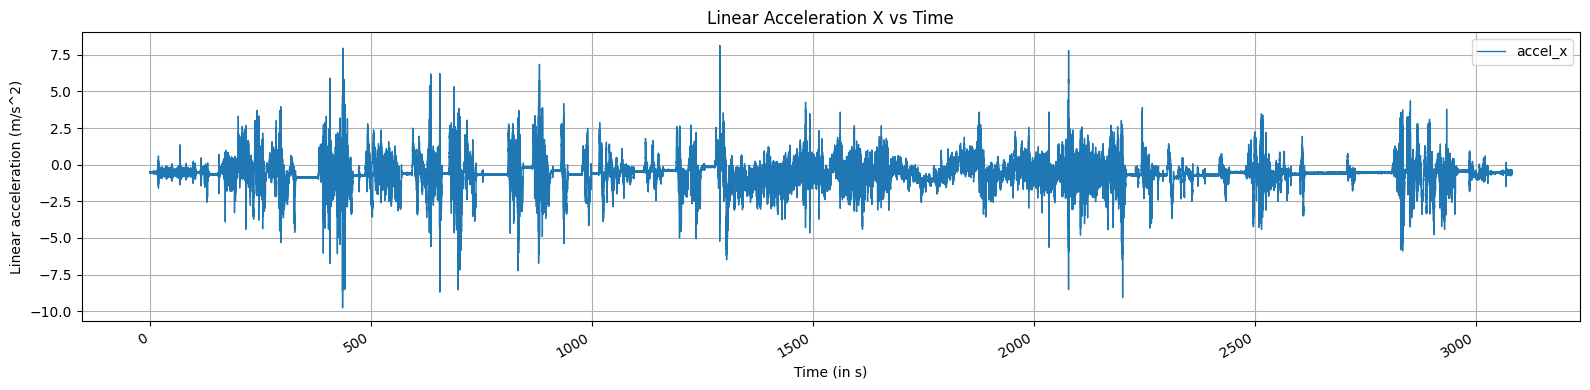

In [6]:
# plot linear acceleration x vs time (uses merged_df from earlier cell)

accel_x_col = 'field.linear_acceleration.x'

# prefer imu rows (gps rows will have NaNs for acceleration)
imu_data = merged_df[merged_df['source'] == 'imu']

# drop rows where both axes are NaN
imu_data = imu_data.dropna(subset=[accel_x_col], how='all')

if imu_data.empty:
    raise ValueError("No IMU acceleration data available to plot.")

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(imu_data.index, imu_data[accel_x_col], label='accel_x', linewidth=1)

ax.set_xlabel('Time (in s)')
ax.set_ylabel('Linear acceleration (m/s^2)')
ax.set_title('Linear Acceleration X vs Time')
ax.legend()
ax.grid(True)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

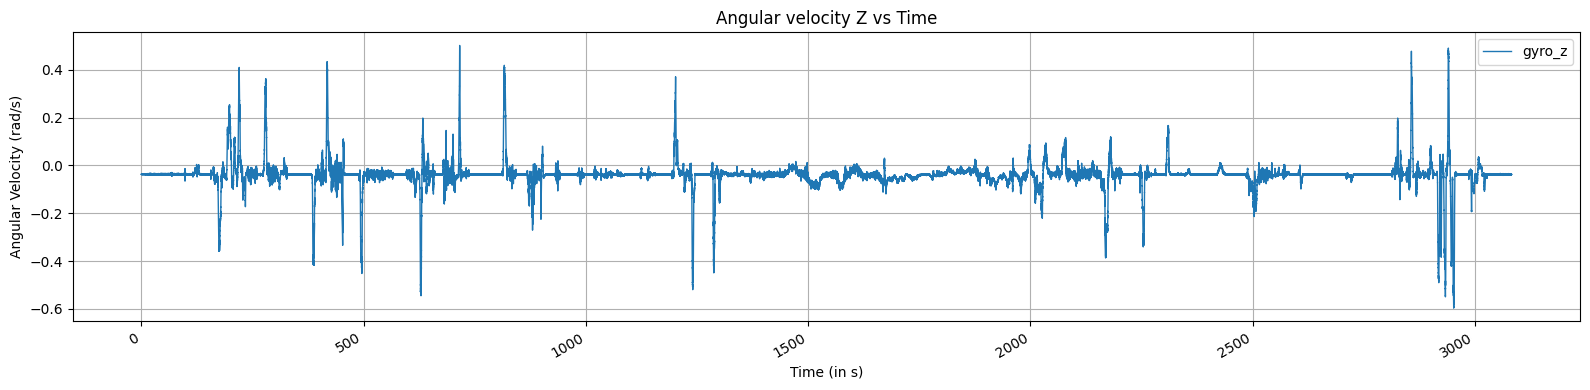

In [7]:
angular_z_col = 'field.angular_velocity.z'

# prefer imu rows (gps rows will have NaNs for acceleration)
imu_data = merged_df[merged_df['source'] == 'imu']

# drop rows where both axes are NaN
imu_data = imu_data.dropna(subset=[angular_z_col], how='all')
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(imu_data.index, imu_data[angular_z_col], label='gyro_z', linewidth=1)

ax.set_xlabel('Time (in s)')
ax.set_ylabel('Angular Velocity (rad/s)')
ax.set_title('Angular velocity Z vs Time')
ax.legend()
ax.grid(True)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [8]:
# compute yaw (heading) from quaternions and add to merged_df
if 'merged_df' not in globals():
    raise NameError("merged_df is not defined in this notebook session")

for c in ('field.orientation.x','field.orientation.y','field.orientation.z','field.orientation.w'):
    if c not in merged_df.columns:
        raise KeyError(f"missing column: {c}")

qx = merged_df['field.orientation.x'].values
qy = merged_df['field.orientation.y'].values
qz = merged_df['field.orientation.z'].values
qw = merged_df['field.orientation.w'].values

valid = ~np.isnan(qx) & ~np.isnan(qy) & ~np.isnan(qz) & ~np.isnan(qw)
yaw = np.full(len(merged_df), np.nan)

if valid.any():
    n = np.sqrt(qw[valid]**2 + qx[valid]**2 + qy[valid]**2 + qz[valid]**2)
    qw_n = qw[valid]/n; qx_n = qx[valid]/n; qy_n = qy[valid]/n; qz_n = qz[valid]/n
    yaw[valid] = np.arctan2(2*(qw_n*qz_n + qx_n*qy_n), 1 - 2*(qy_n**2 + qz_n**2))

merged_df['yaw'] = yaw
yaw_filled = merged_df['yaw'].fillna(method='ffill').fillna(method='bfill')



WARNING	matplotlib.legend:legend.py:_parse_legend_args()- No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


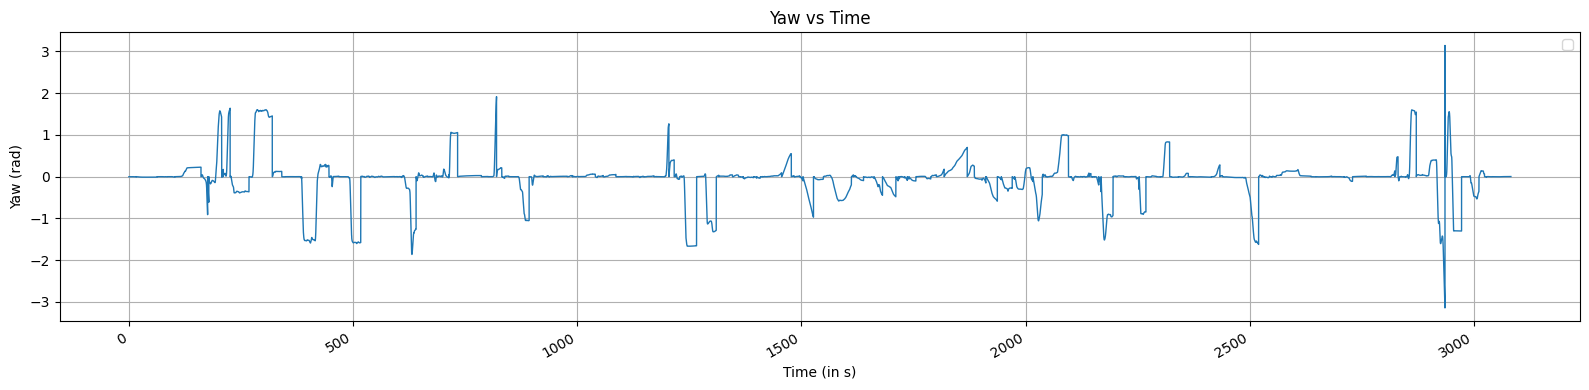

In [9]:
yaw = 'yaw'

# prefer imu rows (gps rows will have NaNs for acceleration)
imu_data = merged_df[merged_df['source'] == 'imu']

# drop rows where both axes are NaN
imu_data = imu_data.dropna(subset=[yaw], how='all')
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(imu_data.index, imu_data[yaw],  linewidth=1)

ax.set_xlabel('Time (in s)')
ax.set_ylabel('Yaw (rad)')
ax.set_title('Yaw vs Time')
ax.legend()
ax.grid(True)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

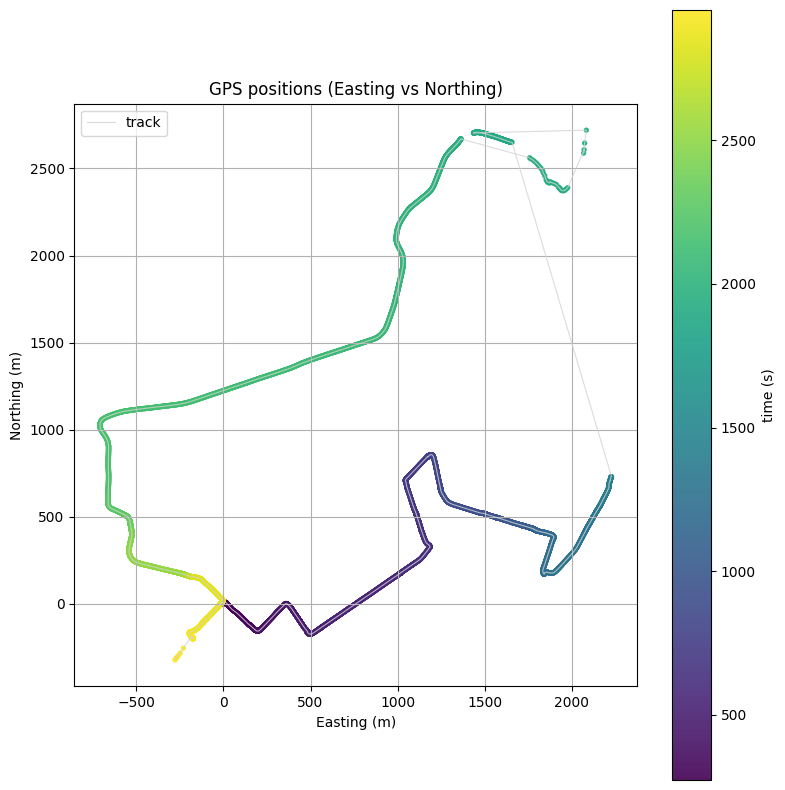

In [10]:
import utm 
# convert gps lat/lon to UTM Easting/Northing

xy = []
east_offset =0.0
north_offset=0.0
for lat, lon in zip(merged_df['field.latitude'], merged_df['field.longitude']):
    try:
        easting, northing, _, _ = utm.from_latlon(lat, lon)
        if east_offset==0.0:
            east_offset=easting
            north_offset=northing
        easting -= east_offset
        northing -= north_offset
        xy.append((easting, northing))
    except utm.OutOfRangeError:
        xy.append((np.nan, np.nan))

merged_df[['Easting', 'Northing']] = pd.DataFrame(xy, index=merged_df.index)

gps_pts = merged_df.dropna(subset=['Easting', 'Northing'])

fig, ax = plt.subplots(figsize=(8, 8))
# track line
ax.plot(gps_pts['Easting'], gps_pts['Northing'], color='lightgray', linewidth=0.8, alpha=0.8, label='track')
# colored scatter by time
sc = ax.scatter(gps_pts['Easting'], gps_pts['Northing'], c=gps_pts.index.values, cmap='viridis', s=8, alpha=0.9)
cbar = fig.colorbar(sc, ax=ax, label='time (s)')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_title('GPS positions (Easting vs Northing)')
ax.set_aspect('equal', 'box')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

WARNING	matplotlib.legend:legend.py:_parse_legend_args()- No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


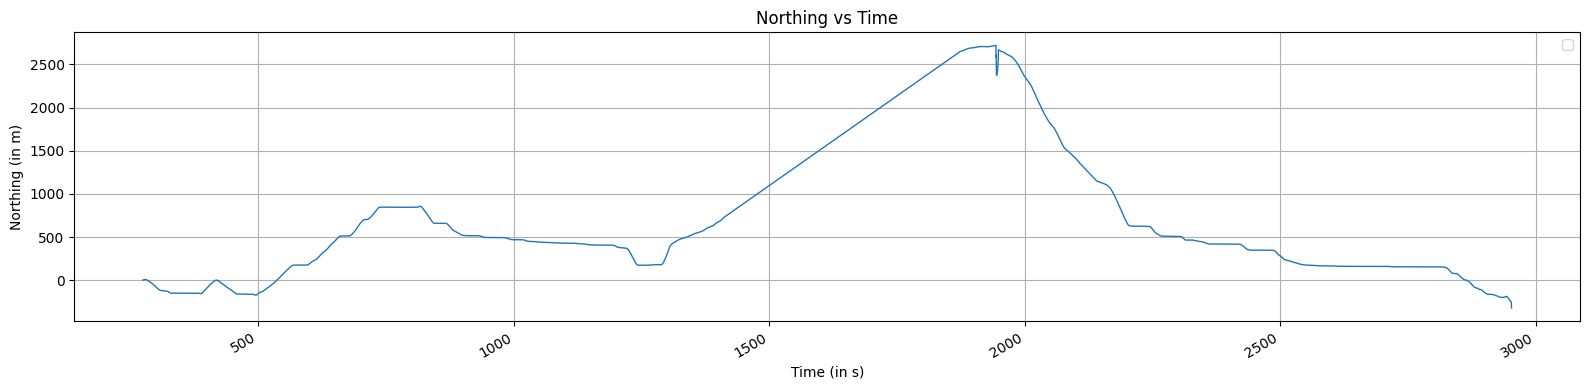

<bound method NDFrame.head of                            %time  field.header.seq   field.header.stamp  \
timestamp                                                                 
273.594651   1697739552336645125              3057  1697739552336282730   
273.695284   1697739552437278031              3058  1697739552436939477   
273.794535   1697739552536529166              3059  1697739552536070823   
273.900623   1697739552642617454              3060  1697739552642065048   
273.995243   1697739552737236979              3061  1697739552736932516   
...                          ...               ...                  ...   
2952.588770  1697742231330764371             29783  1697742231330468416   
2952.688358  1697742231430351842             29784  1697742231429931163   
2952.786658  1697742231528651574             29785  1697742231528051853   
2952.892917  1697742231634911339             29786  1697742231634332656   
2952.988639  1697742231730633225             29787  169774223172960948

In [11]:
northing_gps = 'Northing'

# prefer imu rows (gps rows will have NaNs for acceleration)
gps_data = merged_df[merged_df['source'] == 'gps']

# drop rows where both axes are NaN
gps_data = gps_data.dropna(subset=[northing_gps], how='all')
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(gps_data.index, gps_data[northing_gps], linewidth=1)

ax.set_xlabel('Time (in s)')
ax.set_ylabel('Northing (in m)')
ax.set_title('Northing vs Time')
ax.legend()
ax.grid(True)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

print(gps_data.head)

WARNING	matplotlib.legend:legend.py:_parse_legend_args()- No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


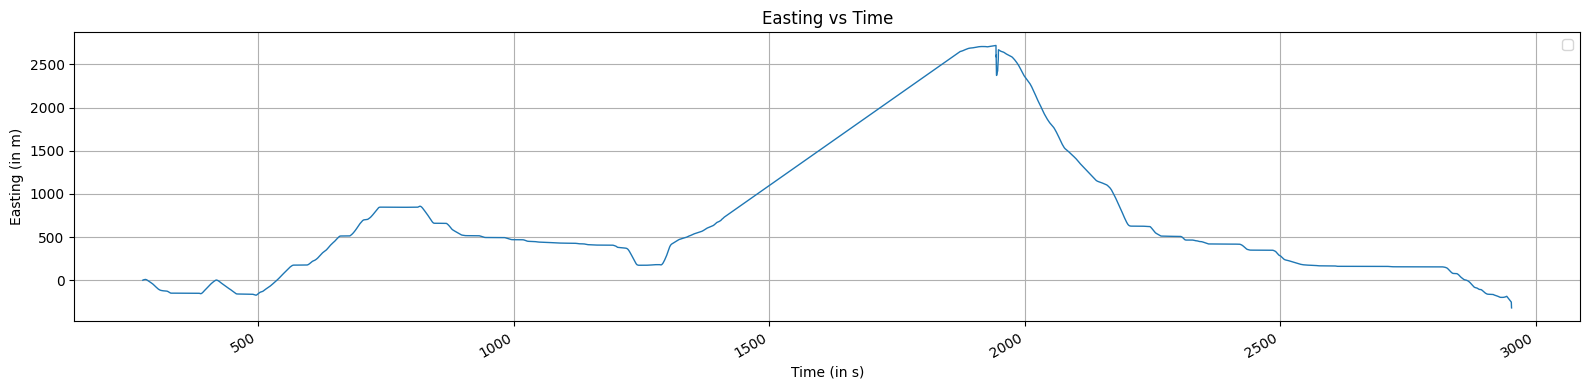

<bound method NDFrame.head of                            %time  field.header.seq   field.header.stamp  \
timestamp                                                                 
273.594651   1697739552336645125              3057  1697739552336282730   
273.695284   1697739552437278031              3058  1697739552436939477   
273.794535   1697739552536529166              3059  1697739552536070823   
273.900623   1697739552642617454              3060  1697739552642065048   
273.995243   1697739552737236979              3061  1697739552736932516   
...                          ...               ...                  ...   
2952.588770  1697742231330764371             29783  1697742231330468416   
2952.688358  1697742231430351842             29784  1697742231429931163   
2952.786658  1697742231528651574             29785  1697742231528051853   
2952.892917  1697742231634911339             29786  1697742231634332656   
2952.988639  1697742231730633225             29787  169774223172960948

In [12]:
easting_gps = 'Northing'

# prefer imu rows (gps rows will have NaNs for acceleration)
gps_data = merged_df[merged_df['source'] == 'gps']

# drop rows where both axes are NaN
gps_data = gps_data.dropna(subset=[easting_gps], how='all')
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(gps_data.index, gps_data[easting_gps], linewidth=1)

ax.set_xlabel('Time (in s)')
ax.set_ylabel('Easting (in m)')
ax.set_title('Easting vs Time')
ax.legend()
ax.grid(True)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

print(gps_data.head)

The GPS data starts giving valid data from 273.594651s timestamp, we will consider the first 150s for IMU bias analyis and the move data will be considered from the mentioned timestamp.

In [13]:
# create df_stat containing rows from timestamp 0 up to 150 seconds
if 'merged_df' not in globals():
    raise NameError("merged_df is not defined in this notebook session")

df_stat = merged_df.loc[(merged_df.index >= 0) & (merged_df.index <= 150)].copy()
print(f"df_stat shape: {df_stat.shape}")




df_stat shape: (29999, 24)


Calculting bias and variance for Linear Acceleration x and Angular velocity z as they will be modeled as the control inputs

In [14]:
acc_x_bias = df_stat['field.linear_acceleration.x'].median()
acc_x_var = df_stat['field.linear_acceleration.x'].var()
print(f"Acceleration x Variance: {acc_x_var}, Bias: {acc_x_bias}")

ang_z_bias = df_stat['field.angular_velocity.z'].median()
ang_z_var = df_stat['field.angular_velocity.z'].var()
print(f"Angular Z Variance: {ang_z_var}, Bias: {ang_z_bias}")

merged_df['Acc_x'] = merged_df['field.linear_acceleration.x'] - acc_x_bias
merged_df['Ang_z'] = merged_df['field.angular_velocity.z'] - ang_z_bias

Acceleration x Variance: 0.04190520329159846, Bias: -0.5404067039489746
Angular Z Variance: 2.648406127338049e-05, Bias: -0.0363155379891395


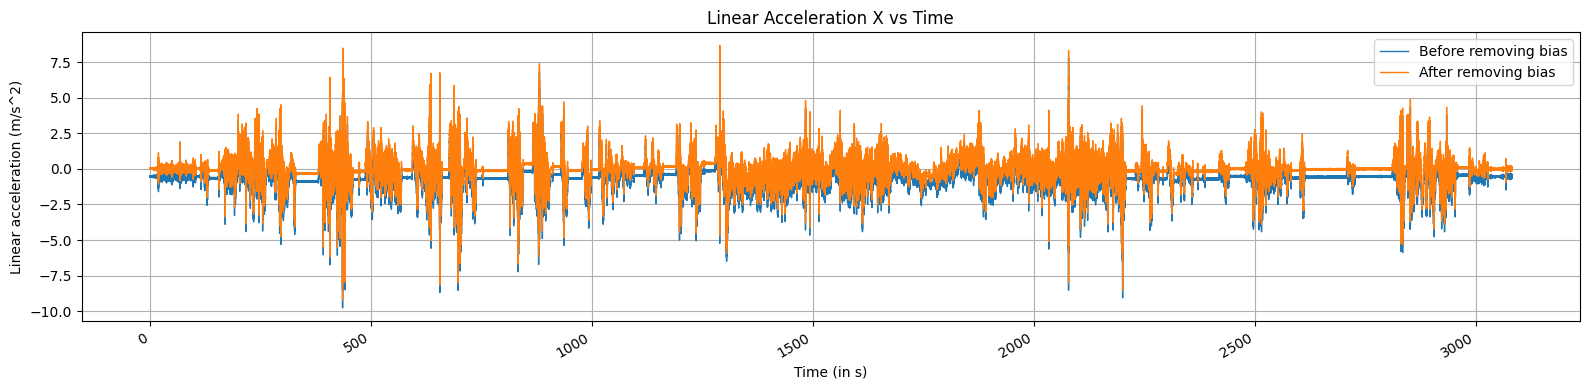

In [15]:
# plot linear acceleration x vs time (uses merged_df from earlier cell)

accel_x_col = 'field.linear_acceleration.x'

# prefer imu rows (gps rows will have NaNs for acceleration)
imu_data = merged_df[merged_df['source'] == 'imu']

# drop rows where both axes are NaN
imu_data = imu_data.dropna(subset=[accel_x_col], how='all')

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(imu_data.index, imu_data[accel_x_col], label='Before removing bias', linewidth=1)
ax.plot(imu_data.index, imu_data['Acc_x'], label='After removing bias', linewidth=1)

ax.set_xlabel('Time (in s)')
ax.set_ylabel('Linear acceleration (m/s^2)')
ax.set_title('Linear Acceleration X vs Time')
ax.legend()
ax.grid(True)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

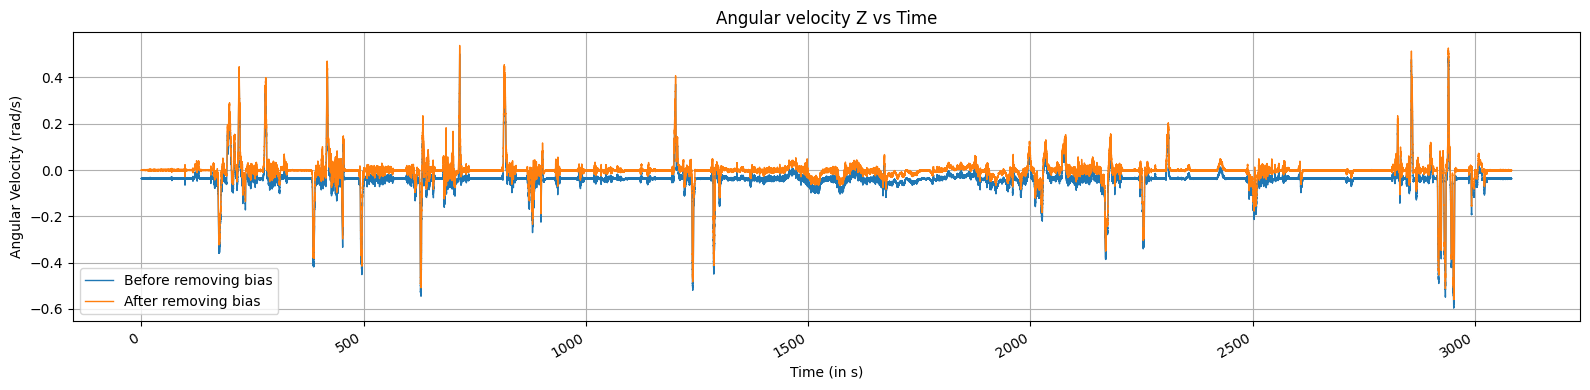

In [16]:
angular_z_col = 'field.angular_velocity.z'

# prefer imu rows (gps rows will have NaNs for acceleration)
imu_data = merged_df[merged_df['source'] == 'imu']

# drop rows where both axes are NaN
imu_data = imu_data.dropna(subset=[angular_z_col], how='all')
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(imu_data.index, imu_data[angular_z_col], label='Before removing bias', linewidth=1)
ax.plot(imu_data.index, imu_data['Ang_z'], label='After removing bias', linewidth=1)

ax.set_xlabel('Time (in s)')
ax.set_ylabel('Angular Velocity (rad/s)')
ax.set_title('Angular velocity Z vs Time')
ax.legend()
ax.grid(True)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [17]:
# from scipy.signal import butter, lfilter

# fs = 200.0  # Sampling frequency in Hz
# order=4
# nyquist = 0.5 * fs

# def butter_lowpass_filter(data, cutoff, fs, order):
#     normal_cutoff = cutoff / nyquist
#     b, a = butter(order, normal_cutoff, btype='low', analog=False)
#     filtered_data = lfilter(b, a, data)
#     return filtered_data

# #sApply the filter to the specified columns
# cutoff_freq = 3.0  # Cutoff frequency in Hz
# merged_df['linear_x_filtered'] = butter_lowpass_filter(merged_df['Acc_x'], cutoff_freq, fs, order)
# merged_df['angular_z_filtered'] = butter_lowpass_filter(merged_df['Ang_z'], cutoff_freq, fs, order)



In [18]:
# angular_z_col = 'angular_z_filtered'

# # prefer imu rows (gps rows will have NaNs for acceleration)
# imu_data = merged_df[merged_df['source'] == 'imu']

# # drop rows where both axes are NaN
# imu_data = imu_data.dropna(subset=[angular_z_col], how='all')
# fig, ax = plt.subplots(figsize=(16, 4))
# ax.plot(imu_data.index, imu_data['angular_z_filtered'], label='Before removing bias', linewidth=1)
# # ax.plot(imu_data.index, imu_data['Ang_z'], label='After removing bias', linewidth=1)

# ax.set_xlabel('Time (in s)')
# ax.set_ylabel('Angular Velocity (rad/s)')
# ax.set_title('Angular velocity Z vs Time')
# ax.legend()
# ax.grid(True)
# fig.autofmt_xdate()
# plt.tight_layout()
# plt.show()

In [19]:
df_move = merged_df.loc[(merged_df.index >= 273.594651)].copy()
print(f"df_move shape: {df_move.shape}")
print(merged_df.columns)


df_move shape: (583477, 26)
Index(['%time', 'field.header.seq', 'field.header.stamp',
       'field.status.status', 'field.latitude', 'field.longitude',
       'field.altitude', 'field.position_covariance0',
       'field.position_covariance4', 'field.position_covariance8', 'source',
       'field.orientation.x', 'field.orientation.y', 'field.orientation.z',
       'field.orientation.w', 'field.angular_velocity.x',
       'field.angular_velocity.y', 'field.angular_velocity.z',
       'field.linear_acceleration.x', 'field.linear_acceleration.y',
       'field.linear_acceleration.z', 'yaw', 'Easting', 'Northing', 'Acc_x',
       'Ang_z'],
      dtype='object')


### Kalman filter implementation

In [28]:
def predict(state, state_covar, state_matrix, control, control_covar):
    
    prior = state_matrix @ state + control
    prior_covar = state_matrix @ state_covar @ state_matrix.T + control_covar
    
    return prior, prior_covar

In [29]:
def update(measurement, measurement_covar, prior, prior_covar, measurement_matrix):
    
    residual = measurement - measurement_matrix@prior
    kalman_gain= prior_covar@(measurement_matrix.T)@np.linalg.inv(measurement_matrix@prior_covar@(measurement_matrix.T)+ measurement_covar)
    posterior = prior + kalman_gain@residual
    posterior_covar = (np.eye(4) - kalman_gain@measurement_matrix)@prior_covar
    
    return posterior, posterior_covar

In [ ]:
# Based on GPS tagged row input
measurement_matrix = np.zeros((3,4), dtype=float)
measurement_matrix[0,0] = 1
measurement_matrix[1,1] = 1
measurement_matrix[1,1] = 1

def get_measurement(df_row, prev_df_row):
    """
    The Measurement vector is basically the [x,y, theta] of the ego vehicle.
    I have modeled theta covariance such that it is dependent on the time duration from the last GPS signal.
    """
    
    x = df_row['Easting']
    y = df_row['Northing']
    # creates a line between the two gps points
    theta = np.arctan2(x - prev_df_row['Easting'], y - prev_df_row['Northing'])
    
    measurement = np.array([x, y, theta])
    
    sigma_x = df_row['field.position_covariance0']
    sigma_y = df_row['field.position_covariance4']
    delta_t = df_row.name - prev_df_row.name
    
    # Penalizing yaw reliance in case the data disappears for a long time
    sigma_theta = delta_t**2*sigma_x
    
    measurement_covar = np.diag([sigma_x, sigma_y, sigma_theta])

    
    return measurement, measurement_covar, measurement_matrix

In [ ]:

sigma_ax = acc_x_var
sigma_wz = ang_z_var
control_covar = np.diag([sigma_ax, sigma_wz])
delta_t=0.005
# Based on IMU measurement row
def get_prior(row, state, state_covar):
    """
    Calculates the prior for the prediction step.
    Assumes a state vector of [x, y, theta, vx].
    control vector is [ax, wz]
    """
    # Unpack current state for clarity
    x, y, theta, vx = state
    

    ax = row['Acc_x']
    wz = row['Ang_z']

    # State Prediction (Non-linear model)

    prior = np.array([
        x + vx * np.cos(theta) * delta_t,
        y + vx * np.sin(theta) * delta_t,
        theta + wz * delta_t,
        vx + ax * delta_t
    ])
    
    # Wrap angle to [-pi, pi] for numerical stability
    prior[2] = (prior[2] + np.pi) % (2 * np.pi) - np.pi

    # State Transition Jacobian (F)
    # This is the linearization of the state prediction model
    F = np.eye(4, dtype=float)
    F[0, 2] = -vx * np.sin(theta) * delta_t
    F[0, 3] = np.cos(theta) * delta_t
    F[1, 2] = vx * np.cos(theta) * delta_t
    F[1, 3] = np.sin(theta) * delta_t

    # 3. Map Input Noise to Process Noise
    # Create the mapping matrix G
    G = np.zeros((4, 2))
    G[2, 1] = delta_t  # Effect of wz noise on theta
    G[3, 0] = delta_t  # Effect of ax noise on vx
    
    # Calculate Noise Covariance Matrix Q
    Q = G @ control_covar @ G.T

    # Covariance Prediction
    prior_covar = F @ state_covar @ F.T + Q
    
    return prior, prior_covar

    

### Kalman filter loop

In [49]:
prev_imu_row = None
prev_gps_row = None
state = np.array([0.0, 0.0, 0.0, 0.0])
state_covar = np.diag([0.001, 0.001, 0.001, 0.001])

path_x = []
path_y = []
path_theta = []
timestamps = []
for index, row in df_move.iterrows():
    if row['source'] == 'imu':
        # Apply the prediction step
        if prev_imu_row is None:
            prev_imu_row = row
            continue
        # state_matrix, control, control_covar = get_prior(row, prev_imu_row, state)
        state, state_covar = get_prior(row, state, state_covar)
        prev_imu_row =row

    elif row['source'] == 'gps':
        # Apply the measurement update step
        if prev_gps_row is None:
            prev_gps_row = row
            continue
        measurement, measurement_covar, measurement_matrix = get_measurement(row, prev_gps_row)
    
        state, state_covar = update(measurement, measurement_covar, state, state_covar, measurement_matrix)
        prev_gps_row= row
    
    # Store the estimated x and y coordinates
    path_x.append(state[0])
    path_y.append(state[1])
    path_theta.append(state[2])
    timestamps.append(row.name)

# Create a DataFrame from the collected data
kalman_df = pd.DataFrame({
    'timestamp': timestamps,
    'estimated_x': path_x,
    'estimated_y': path_y,
    'estimated_theta': path_theta
})

        

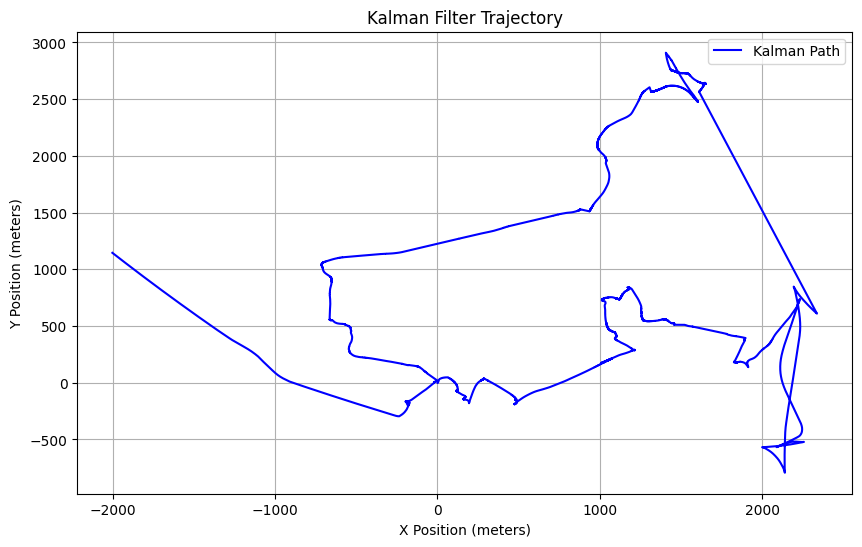

In [53]:
# Plot the dead reckoning path
plt.figure(figsize=(10, 6))
plt.plot(path_x, path_y, label='Kalman Path', color='blue')
plt.title('Kalman Filter Trajectory')
plt.xlabel('X Position (meters)')
plt.ylabel('Y Position (meters)')
plt.grid(True)

plt.legend()
plt.show()


WARNING	matplotlib.legend:legend.py:_parse_legend_args()- No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


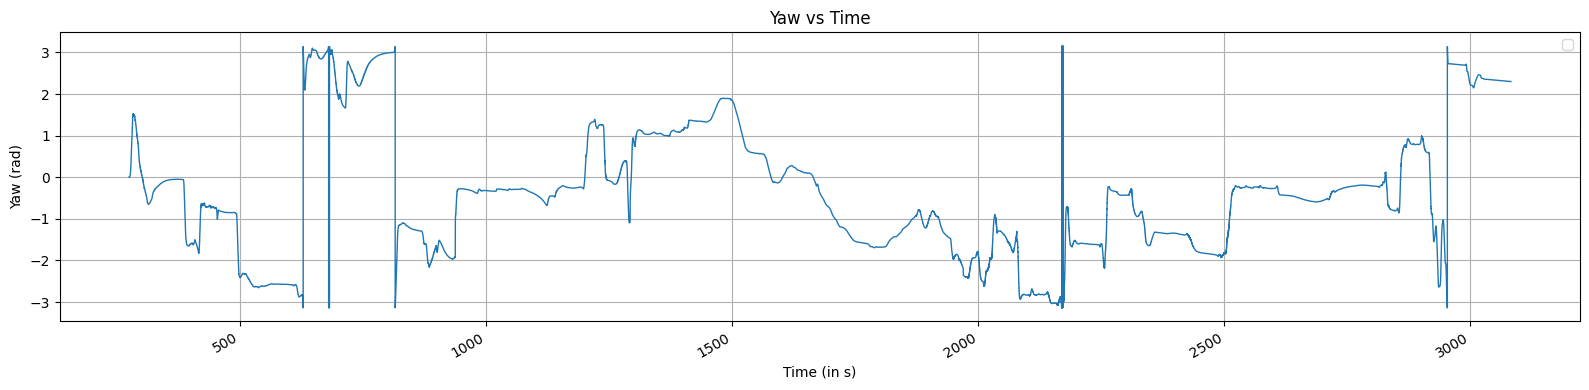

In [55]:

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(kalman_df['timestamp'], kalman_df['estimated_theta'],  linewidth=1)

ax.set_xlabel('Time (in s)')
ax.set_ylabel('Yaw (rad)')
ax.set_title('Yaw vs Time')
ax.legend()
ax.grid(True)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

Dead reckoning is basically running the predict step without the getting any updates from the GPS, apart from the initial values.

In [40]:
#Dead reckoning code

prev_imu_row = None
prev_gps_row = None
state = np.array([0.0, 0.0, 0.0, 0.0])
state_covar = np.diag([0.001, 0.001, 0.001, 0.001])

path_x = []
path_y = []
for index, row in df_move.iterrows():
    if row['source'] == 'imu':
        # Apply the prediction step
        if prev_imu_row is None:
            prev_imu_row = row
            continue
        # state_matrix, control, control_covar = get_prior(row, prev_imu_row, state)
        state, state_covar = get_prior(row, state, state_covar)
        prev_imu_row =row
    
    # Store the estimated x and y coordinates
    path_x.append(state[0])
    path_y.append(state[1])
        

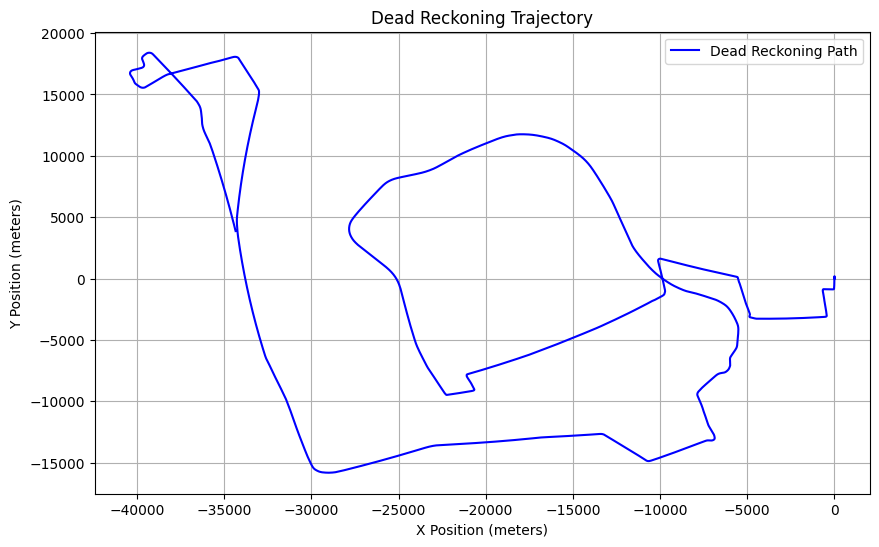

In [41]:
# Plot the dead reckoning path
plt.figure(figsize=(10, 6))
plt.plot(path_x, path_y, label='Dead Reckoning Path', color='blue')
plt.title('Dead Reckoning Trajectory')
plt.xlabel('X Position (meters)')
plt.ylabel('Y Position (meters)')
plt.grid(True)

plt.legend()
plt.show()



## Results

The lack of stationary analysis of the IMU for drift calculation has a huge impact on the results as can be seen from the Dead reckoning plot. Good Error analysis on the IMU acceleration x, Angular velocity z, and theta from the quaternion will give a better estimate. I have not estimated them as the problem statement mentioned specifically not to do so: "You can ignore computing accelerometer and gyroscope biases for this project. Estimate theminitially by averaging the readings at rest and subtracting them from your readings to unbias themeasurements."

The Kalman filter plot is an upgrade over the Dead Reckoning plot, leveraging the GPS correction steps. However we can observe it shows similar drifts when the vehicle loses GPS signals for a long duration and the Kalman filter is effectively a Dead Reckoning algorithm for that part.

#### Advantages

It is a lightweight algorithm to merge a low-frequency, low-accuracy data with a high-frequency but prone to drift data. It can handle lossy data streams and effectively rely on the other data stream. It propagates the covariance precisely which always gives an idea of the accuracy of the data. In real-time systems it only needs to store the current state and covariance making it efficient in storage-terms

#### Limitations

Kalman filter is dependent on well-calibrated sensors streaming data. As it is often implemented as a real-time algorithm, pre-processing the datastream is not possible making it heavily reliant on calibration. The sensor system must be synced and extrinsically calibrated as well.